NMT (seq2seq) in fastai v1

Start with this:<br>
https://gist.github.com/ohmeow/fe91aed6267cd779946ab9f10eccdab9

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

# Load data, split, build DataBunch

In [3]:
def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    x_max_len = max([len(s[0]) for s in samples])
    y_max_len = max([len(s[1]) for s in samples])
    
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    return x_res, y_res

class Seq2SeqDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:        
        """Function that transform the `datasets` in a `DataBunch` for classification.  Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch    

In [4]:
PATH = Path('./data/seq2seq/')
bs = 64

## load the saved data.
data = load_data(PATH, "full_es_en_data_spacyTok.pkl")

In [5]:
b = next(iter(data.train_dl))
b[0].shape, b[1].shape

(torch.Size([64, 255]), torch.Size([64, 252]))

In [6]:
b[0].shape

torch.Size([64, 255])

In [7]:
b[1].shape

torch.Size([64, 252])

In [8]:
len(data.label_list.train.x.vocab.itos), len(data.label_list.train.y.vocab.itos)

(35541, 58838)

In [9]:
len(data.label_list.train.x.vocab.itos), data.label_list.train.vocab.itos[:20]

(35541,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  ',',
  '.',
  'of',
  'to',
  'and',
  'in',
  'that',
  'a',
  'is',
  'we'])

# Build a model for Seq2Seq

Big help from this link from the old course + looking at the `Transformer` code and adapting <br>
https://github.com/kheyer/ML-DL-Projects/blob/master/Seq2Seq%20Transformer/Transformer.ipynb

and here:<br>
https://nbviewer.jupyter.org/github/fastai/fastai/blob/6ba17b21599a6fc441794ffd130bc31b5333b4a0/courses/dl2/translate.ipynb



## Build Seq2SeqTransformer

In [10]:
class m_MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.att_q = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_k = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_v = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None, **kwargs):
        "attn -> Linear -> drop -> merge -> LN"
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask, **kwargs))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,x_len = q.size(0),q.size(1) # bs x bptt x d_model
        wq,wk,wv = self.att_q(q), self.att_k(k), self.att_v(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, x_len, -1)

In [11]:
_activ_func = {Activation.ReLU:nn.ReLU(inplace=True), Activation.GeLU:GeLU(), Activation.Swish: Swish}
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., act:Activation=Activation.ReLU, double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), _activ_func[act]]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))
    
class EncDecLayer(nn.Module):
    "Decoder block for seq2seq. Self and target attention combined."
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, act:Activation=Activation.ReLU, double_drop:bool=True,
                 attn_cls:Callable=m_MultiHeadAttention, is_decode=False):
        super().__init__()
        self.is_decode = is_decode
        self.mhra_s    = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        if self.is_decode:
            self.mhra_targ = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)
        
    def forward(self, x:Tensor, enc_out:Tensor=None, src_mask:Tensor=None, mask:Tensor=None, **kwargs):
        assert self.is_decode == (enc_out is not None), "Calling Decode `forward()` with out init `is_decode`"
        x = self.mhra_s(x,x,x, mask=mask, **kwargs)
        if self.is_decode: x = self.mhra_targ(x, enc_out, enc_out, mask=src_mask, **kwargs)
        return self.ff(x)

In [12]:
class Seq2SeqTransformer(nn.Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, vocab_sz:int, tgt_vocab_sz:int, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, 
                 d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=True, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=m_MultiHeadAttention,
                 learned_pos_enc:bool=True, mask:bool=True):
        super().__init__()
        self.mask = mask
        self.encoder = nn.Embedding(vocab_sz, d_model)
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_emb = nn.Dropout(embed_p)
        self.enc_layers = nn.ModuleList([EncDecLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                          ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                          attn_cls=attn_cls, is_decode=False) for k in range(n_layers)])

        self.decoder = nn.Embedding(tgt_vocab_sz, d_model)
        self.pos_dec = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_dec = nn.Dropout(embed_p)
        self.dec_layers = nn.ModuleList([EncDecLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                          ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                          attn_cls=attn_cls, is_decode=True) for k in range(n_layers)])
        
        self.tgt_word_prj = nn.Linear(d_model, tgt_vocab_sz, bias=False)
        nn.init.xavier_normal_(self.tgt_word_prj.weight)
        self.x_logit_scale = (d_model ** -0.5)
        
    def reset(self):pass

    def encode_source(self, x):
        "encode layers to representation"
        bs, x_len = x.size()
        pos = torch.arange(0, x_len, device=x.device, dtype=x.dtype)
        inp = self.drop_emb(self.encoder(x) + self.pos_enc(pos)[None])
        src_mask = (x==1).byte()[:,None,None,:] #[64,5,155,155]
        for layer in self.enc_layers: inp  = layer(inp, mask=src_mask)            
        return inp, src_mask

    def decode_target(self, inp, src_mask, y):
        "decode layers"
        #mask == trg_mask (but trg_mask also masks out all xxpad ids [id==1]  add that here?)
        bs, y_len = y.size()
        pos_y = torch.arange(0, y_len, device=y.device, dtype=y.dtype)
        targ = self.drop_dec(self.decoder(y) + self.pos_dec(pos_y)[None])
        nopeak_mask = torch.triu(y.new_ones(y_len, y_len), diagonal=1).byte() if self.mask else None
        targ_mask = (y==1).byte()[:,None,:,None] * nopeak_mask        
        for layer in self.dec_layers: targ = layer(targ, inp, src_mask=src_mask, mask=targ_mask)
        return targ
        
    def forward(self, x, y):
        #encode layers
        inp, src_mask = self.encode_source(x)
        targ = self.decode_target(inp, src_mask, y)
        decoded = self.tgt_word_prj(targ) * self.x_logit_scale
        return [decoded, inp, targ]
    
def init_transformer(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 0., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 1., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)
            

In [13]:
tfm_seq2seq = Seq2SeqTransformer(vocab_sz=len(data.label_list.train.x.vocab.itos),
                       tgt_vocab_sz=len(data.label_list.train.y.vocab.itos),
                       ctx_len=256, n_layers=3, n_heads=5, d_model=300, d_head=None, d_inner=2048)
_ = tfm_seq2seq.apply(init_transformer)

In [14]:
@dataclass
class AppendBatchTargs(Callback):
    "Include the target in the training loop for Decoder mask"
    learn:Learner
    def __init__(self):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target[:,:-1]),
                'last_target':last_target[:,1:]}        
#     def on_batch_begin(self, last_input, last_target, **kwargs):
#         return {'last_input':(last_input, last_target), 'last_target':last_target}

In [15]:
class Seq2SeqLearner(RNNLearner):
    "Subclass of RNNLearner for predictions using Seq2Seq"
    
    def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
                decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text`."
        ## handle predictions for Seq2Seq
        set_trace()
        ds = self.data.single_dl.dataset
        self.model.reset()
        xb,yb = self.data.one_item(text)
        new_idx = []
        for _ in range(n_words): #progress_bar(range(n_words), leave=False):
            res = self.pred_batch(batch=(xb,yb))[0][-1]
            #if len(new_idx) == 0: self.model[0].select_hidden([0])
            if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
            if min_p is not None: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            new_idx.append(idx)
            xb = xb.new_tensor([idx])[None]
        return text + sep + sep.join(decoder(self.data.vocab.textify(new_idx, sep=None)))

In [16]:
learn = Seq2SeqLearner(data, tfm_seq2seq, **{'alpha':0,'beta':0}, callbacks=[AppendBatchTargs()], loss_func=CrossEntropyFlat())
learn.unfreeze()

In [17]:
total_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
f'{total_params:,}'

'56,765,388'

In [18]:
learn.data.batch_size = 16  ## 64 fails to load.  Prob. too big embedding matrix.

In [19]:
learn.fit(1, lr=3e-4)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

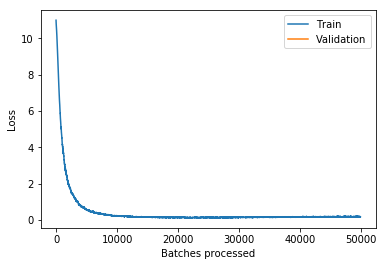

In [26]:
learn.recorder.plot_losses()

In [31]:
x,y = next(iter(learn.data.valid_dl))
preds = learn.model(x,y)
preds[0][0,:].argmax(dim=-1)

tensor([    2,     5,    11,     5,    35,    23,    83,   621,    19,   209,
          486,    10,   724,    10,   820,    10,   952,    10,  1210,    10,
         1414,    10,  1657,    10,  1322,    10,  1471,    10,   985,    10,
         1880,    10,  2167,    10,  2270,    10,  2091,    10,   909,    10,
         1803,    10,  2664,    10,  2780,    10,  1192,    10,  2596,    10,
         4019,    10,  4283,    10,  3091,    10,  3651,    10,  4856,    10,
         4271,    10,  4792,    10,  4964,    10,  3745,    10,  5538,    10,
         5664,    10,  4074,    10,  5296,    10,  5858,    10,  6064,    10,
         6978,    10,  4424,    10,  6428,    10,  6963,    10,  6632,    10,
         7383,    10,  8393,    10,  2530,    10,  5315,    10,  4053,    10,
         7715,    10,  2282,    10,  7931,    10, 11149,    10,  5890,    10,
         8345,    10,  2640,    10,  7729,    10,  6045,    10,  7007,    10,
         8048,    10,  3974,    10,  5856,    10,  6467,    10, 

In [32]:
x_itos = data.label_list.train.x.vocab.itos
y_itos = data.label_list.train.y.vocab.itos

In [33]:
i = 0
for i in range(5):
    print(' '.join([x_itos[o] for o in x[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in y[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in preds[0][i,:].argmax(dim=1) if o!=1]))
    print()

xxbos xxmaj the xxmaj commission can not accept amendments 1 , 2 , 3 , 5 , 6 , 7 , 9 , 12 , 13 , 15 , 17 , 22 , 23 , 24 , 25 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 35 , 37 , 38 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 51 , 52 , 54 , 55 , 56 , 57 , 58 , 66 , 69 , 70 , 71 , 75 , 77 , 80 , 82 , 84 , 85 , 86 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 98 , 99 , 100 , 106 , 109 , 110 , 111 , 112 , 113 , 114 , 118 , 129 , 131 , 133 , 134 , 135 , 136 , 137 , 138 , 143 , 150 , 151 , 152 , 153 , 154 , 155 , 156 , 160 , 162 , 164 , 166 , 167 , 168 , 169 , 170 , 173 , 174 , 177 , 178 , 179 , 182 , 189 , 206 , 212 , 214 , 216 , 218 , 219 , 222 , 223 , 224 , 225 , 226 , 227 , 228 , 229 , 230 , 231 , 232 , 233 , 234 , 237 , 238 , 239 , 240 ,
xxbos xxmaj la xxmaj comisión no puede aceptar las enmiendas 1 , 2 , 3 , 5 , 6 , 7 , 9 , 12 , 13 , 15 , 17 , 22 , 23 , 24 , 25 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 35 , 37 , 38 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 51 , 52 , 54 , 55 , 56 , 57 , 58 , 66 , 69 , 70 , 7

In [145]:
inp, src_mask = learn.model.encode_source(x[i,:].unsqueeze(0))
i,x.shape,inp.shape,src_mask

(8,
 torch.Size([16, 255]),
 torch.Size([1, 255, 300]),
 tensor([[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1]]]], device='cuda:0', dtype=torch.ui

In [132]:
targ = learn.model.decode_target(inp, src_mask, y[i,:].unsqueeze(0))
learn.model.tgt_word_prj(targ).shape

torch.Size([1, 252, 58838])

In [133]:
learn.model.tgt_word_prj(targ).argmax(dim=-1)

tensor([[    2,     5,    51,    65,     6,  1217,    59,  3549,   149,   658,
            60,     9,    11,     5,   333,     5,   690,    10,    14,   224,
             9,    11,     5,    35,     9,     5,   613,    16,     5,    90,
             5,  1205,    10,    33,    11,    92,     9,     5,   140,    20,
             5,    49,    22,    11,    13,    21,  8765,    28,   104,    17,
            19,  1395, 10063,  1147,    11,     5,   140,  7383,   149,  1803,
           149,     6,  2960,   594,    17,    11,  2273,     9,    19,  5045,
             9,  3163,  3273,    10,    11,     5,   140,  7383,   149,  7264,
           149,     6,  2960,   594,    17,    11,  2273,     9,    19,  5045,
             9,  4806,    10,    11,     5,   140,  7251,   149,  2023,   149,
             6,  2960,  2657,    17,    11,  2273,     9,    18,  2397,     9,
          9219,  8080,     9,    11,   370,    10,    11,     5,   140,  6045,
           149,  4283,   149,     6,  2960,   594,  

In [134]:
learn.data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [ ]:
    def forward(self, x, y):
        #encode layers
        inp, src_mask = self.encode_source(x)
        targ = self.decode_target(inp, src_mask, y)
        decoded = self.tgt_word_prj(targ) * self.x_logit_scale
        return [decoded, inp, targ]

In [164]:
y.shape

torch.Size([16, 252])

tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [183]:
memory, src_mask = learn.model.encode_source(x[i,:].unsqueeze(0))
# ys = torch.ones(1, 1).fill_(learn.data.vocab.stoi[BOS]).type_as(x.data)
# ys = torch.ones(1, 1).fill_(42).type_as(x.data)

## make the y's side right!!! other wise POS encoding is wrong!
ys = torch.ones(1, 252).type_as(x.data)
ys[0][0] = 2
ys

tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [180]:
max_len=3
for _ in range(max_len-1):
    out = learn.model.decode_target(memory, src_mask, ys)[:,-1,:] #latest word estimate, can't change history.
    prob = F.softmax(learn.model.tgt_word_prj(out),dim=-1)
    next_i = learn.model.tgt_word_prj(out).argmax(dim=-1).item()
    ys = torch.cat([ys, torch.ones(1,1).type_as(x.data).fill_(next_i)],dim=1)
    print(ys)

tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')
tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [186]:
prob, torch.multinomial(prob,1)

(tensor([[0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0',
        grad_fn=<SoftmaxBackward>), tensor([[1]], device='cuda:0'))

In [160]:
targ = learn.model.decode_target(memory, src_mask, y[i,:].unsqueeze(0))
learn.model.tgt_word_prj(targ).argmax(dim=-1)

tensor([[    2,     5,    51,    65,     6,  1217,    59,  3549,   149,   658,
            60,     9,    11,     5,   333,     5,   690,    10,    14,   224,
             9,    11,     5,    35,     9,     5,   613,    16,     5,    90,
             5,  1205,    10,    33,    11,    92,     9,     5,   140,    20,
             5,    49,    22,    11,    13,    21,  8765,    28,   104,    17,
            19,  1395, 10063,  1147,    11,     5,   140,  7383,   149,  1803,
           149,     6,  2960,   594,    17,    11,  2273,     9,    19,  5045,
             9,  3163,  3273,    10,    11,     5,   140,  7383,   149,  7264,
           149,     6,  2960,   594,    17,    11,  2273,     9,    19,  5045,
             9,  4806,    10,    11,     5,   140,  7251,   149,  2023,   149,
             6,  2960,  2657,    17,    11,  2273,     9,    18,  2397,     9,
          9219,  8080,     9,    11,   370,    10,    11,     5,   140,  6045,
           149,  4283,   149,     6,  2960,   594,  

### Allow modification of prior words

In [140]:
memory, src_mask = learn.model.encode_source(x[i,::].unsqueeze(0))
ys = torch.ones(1, 1).fill_(learn.data.vocab.stoi[BOS]).type_as(x.data)
print(ys)

tensor([[2]], device='cuda:0')


In [141]:
out = learn.model.decode_target(memory, src_mask, ys)
out.shape

torch.Size([1, 1, 300])

In [144]:
learn.model.tgt_word_prj(out).argmax(dim=-1)

tensor([[2]], device='cuda:0')

In [142]:
prob = F.softmax(learn.model.tgt_word_prj(out),dim=-1)
next_i = learn.model.tgt_word_prj(out).argmax(dim=-1).item()
ys = torch.cat([ys, torch.ones(1,1).type_as(x.data).fill_(next_i)],dim=1)
print(ys)

tensor([[2, 2]], device='cuda:0')


In [143]:
learn.model.tgt_word_prj(learn.model.decode_target(memory, src_mask, ys)).argmax(dim=-1)

tensor([[2, 2]], device='cuda:0')

In [73]:
torch.multinomial(prob.squeeze(), 1)

tensor([2], device='cuda:0')

In [75]:
ys

tensor([[2]], device='cuda:0')

In [77]:
learn.model.tgt_word_prj(out).argmax(dim=-1).item()

2

In [ ]:
max_len=10
for i in range(max_len-1):

    out = model.decoder(Variable(ys), memory, src_mask, Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
    prob = F.softmax(model.out(out[:, -1]))
    #_, next_word = torch.max(prob, dim = 1)
    next_word = torch.multinomial(prob, 1)
    next_word = next_word.data[0][0]
    ys = torch.cat([ys, 
                    torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)

In [ ]:
## need to separate encoder/decoder parts.
### Tranaslation will be:
# * Set state from src sentence in encoder (torch.no_grad() to keep state?)
# * start with xxbos token
# * proceed through each step with next word (example below)
# * OR:  beam_search() to get best set of next words up to end.  

In [24]:
## can we use this encoder as a LM for english??